In [2]:
#1 数据加载
import csv
import jieba

# 用户评论数据集
ds_comments = []

# 1. Read the CSV file
with open('data/DMSC.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        vote = int(row['Star'])
        if vote in [0,5]:
            words = jieba.lcut(row['Comment'])   
            ds_comments.append((words, 1 if vote > 0 else 0))  # 1 for positive, 0 for negative

len(ds_comments)

638106

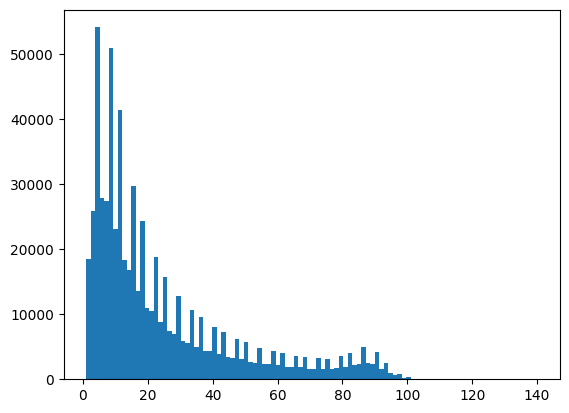

In [3]:
# 分析评论长度，考虑截取过长，过短评论
import matplotlib.pyplot as plt

comments_len = [len(c) for c,v in ds_comments]
plt.hist(comments_len, bins=100)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

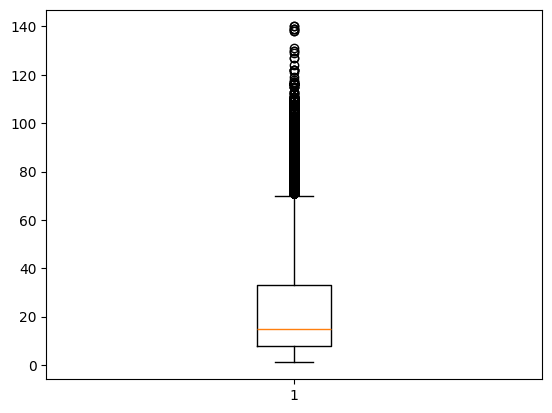

In [4]:
plt.boxplot(comments_len)
plt.show

In [5]:
# 评论词汇长度在10～150之间
ds_comments = [c for c in ds_comments if len(c[0]) in range(10, 150)]

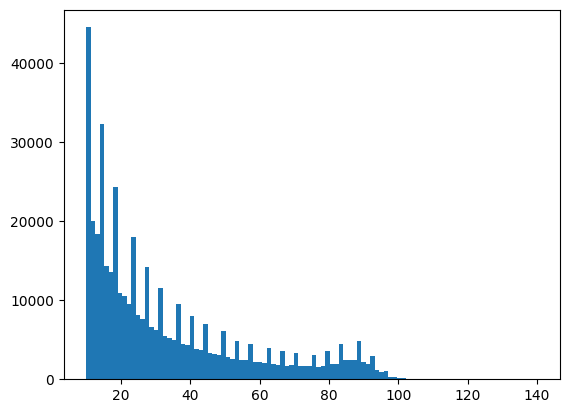

In [6]:
comments_len = [len(c) for c,v in ds_comments]
plt.hist(comments_len, bins=100)
plt.show()

In [7]:
import pickle

with open('data/comments.pkl', 'wb') as f:
    pickle.dump(ds_comments, f)

In [8]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence  # 长度不同张量填充为相同长度
import jieba

In [9]:
def build_from_doc(doc):
    vocab = set()
    for line in doc:
        vocab.update(line[0])

    vocab =  ['PAD','UNK'] + list(vocab)  # PAD: padding, UNK: unknown
    w2idx = {word: idx for idx, word in enumerate(vocab)}
    return w2idx

In [10]:
def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  # padding_idx=0
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
class Comments_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  # padding_idx=0
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):
        # input_ids: (batch_size, seq_len)
        # embedded: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(input_ids)
        # output: (batch_size, seq_len, hidden_size)
        output, (hidden, _) = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  # 取最后一个时间步的输出
        return output

In [11]:
if __name__ == '__main__':
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 加载训练语料
    with open('data/comments.pkl','rb') as f:
        comments_data = pickle.load(f)

    # 构建词汇表
    vocab = build_from_doc(comments_data)
    print('词汇表大小:', len(vocab))

    # 所有向量集合 Embedding（词嵌入）
    emb = nn.Embedding(len(vocab), 100) # 词汇表大小，向量维度

    # 自定义数据转换方法(callback function)回调函数
    # 该函数会在每个batch数据加载时被调用
    def convert_data(batch_data):
        comments, votes = [],[]
        # 分别提取评论和标签
        for comment, vote in batch_data:
            comments.append(torch.tensor([vocab.get(word, vocab['UNK']) for word in comment]))
            votes.append(vote)
        
        # 将评论和标签转换为tensor
        commt = pad_sequence(comments, batch_first=True, padding_value=vocab['PAD'])  # 填充为相同长度
        labels = torch.tensor(votes)
        # 返回评论和标签
        return commt, labels

    # 通过Dataset构建DataLoader
    dataloader = DataLoader(comments_data, batch_size=4, shuffle=True, 
                            collate_fn=convert_data)

    # 构建模型
    # vocab_size: 词汇表大小
    # embedding_dim: 词嵌入维度
    # hidden_size: LSTM隐藏层大小
    # num_classes: 分类数量
    vocab_size = len(vocab)
    embedding_dim = 100
    hidden_size = 128
    num_classes = 2

    model = Comments_Classifier(len(vocab), embedding_dim, hidden_size, num_classes)
    model.to(device)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # 训练模型
    num_epochs = 5
    for epoch in range(num_epochs):
        for i, (cmt, lbl) in enumerate(dataloader):
            cmt = cmt.to(device)
            lbl = lbl.to(device)

            # 前向传播
            outputs = model(cmt)
            loss = criterion(outputs, lbl)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.7f}')

    # 保存模型
    torch.save(model.state_dict(), 'comments_classifier.pth')
    # 模型词典
    torch.save(vocab, 'comments_vocab.pth')

    """"""""""""""""""""""""""""""""""""""""""""""""""

词汇表大小: 159738
Epoch [1/5], Step [10/108353], Loss: 0.5410622
Epoch [1/5], Step [20/108353], Loss: 0.0221813
Epoch [1/5], Step [30/108353], Loss: 0.0008545
Epoch [1/5], Step [40/108353], Loss: 0.0002697
Epoch [1/5], Step [50/108353], Loss: 0.0001621
Epoch [1/5], Step [60/108353], Loss: 0.0001323
Epoch [1/5], Step [70/108353], Loss: 0.0001216
Epoch [1/5], Step [80/108353], Loss: 0.0001083
Epoch [1/5], Step [90/108353], Loss: 0.0001039
Epoch [1/5], Step [100/108353], Loss: 0.0000932
Epoch [1/5], Step [110/108353], Loss: 0.0000895
Epoch [1/5], Step [120/108353], Loss: 0.0000849
Epoch [1/5], Step [130/108353], Loss: 0.0000810
Epoch [1/5], Step [140/108353], Loss: 0.0000818
Epoch [1/5], Step [150/108353], Loss: 0.0000741
Epoch [1/5], Step [160/108353], Loss: 0.0000747
Epoch [1/5], Step [170/108353], Loss: 0.0000717
Epoch [1/5], Step [180/108353], Loss: 0.0000654
Epoch [1/5], Step [190/108353], Loss: 0.0000661
Epoch [1/5], Step [200/108353], Loss: 0.0000639
Epoch [1/5], Step [210/108353], Los

KeyboardInterrupt: 